In [78]:
# Import necessary Libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier


In [79]:
# open json file and load the data into pandas dataframe
df_log = pd.read_json('/Users/ashish/Documents/Vaishali/SpringBoard/TakeHomeChallenges/logins.json',  "r", encoding="utf8")

Part 1 ‐ Exploratory data analysis
---------------------------------------

We will aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Also report/illustrate important features of the demand, such as daily cycles. And find if there are data quality issues.

In [80]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [81]:
df_log.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [82]:
df_log.head(10)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


In [83]:
#indexing inplace
df_log.set_index('login_time', inplace=True)

In [84]:
#aggregate 15 min
df_log['count']=1
df_15min = df_log.resample('15T').sum()

In [85]:
df_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


<AxesSubplot:xlabel='login_time'>

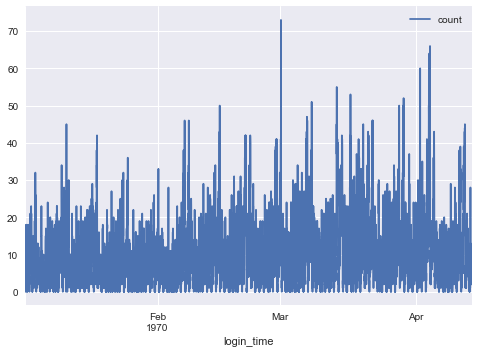

In [86]:
#plot entire series anf check
df_15min.plot()

In [87]:
#though we see some trends, it's staggered to analyse further. 
#let's plot in intervals and see if we can explore any trends

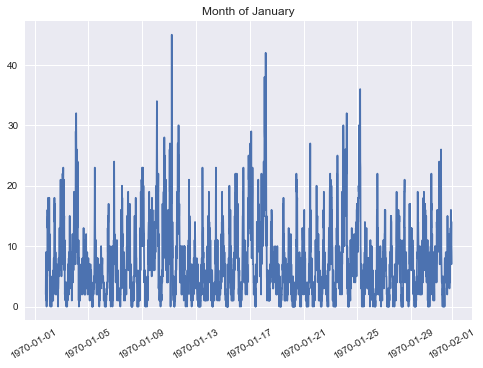

In [88]:
#January
plt.title('Month of January')
plt.plot(df_15min['1970-01-01': '1970-01-31'])
plt.xticks(rotation=30);

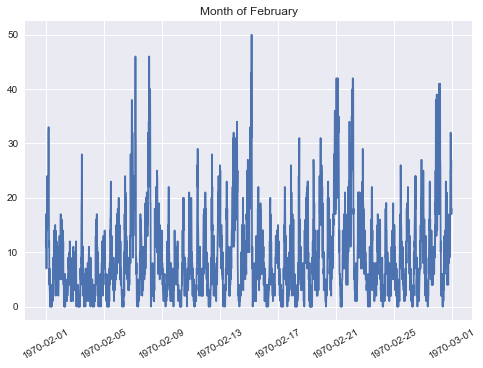

In [89]:
#Feb
plt.title('Month of February')
plt.plot(df_15min['1970-02-01': '1970-02-28'])
plt.xticks(rotation=30);

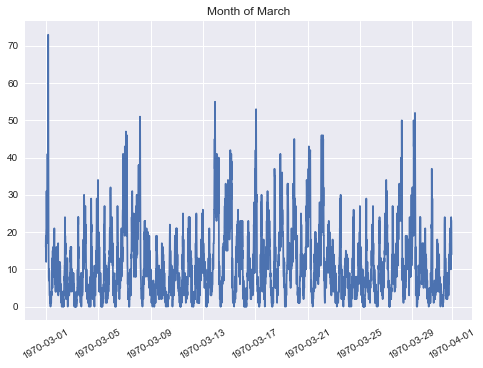

In [90]:
#Mar
plt.title('Month of March')
plt.plot(df_15min['1970-03-01': '1970-03-31'])
plt.xticks(rotation=30);

Text(0, 0.5, 'No. of Logins')

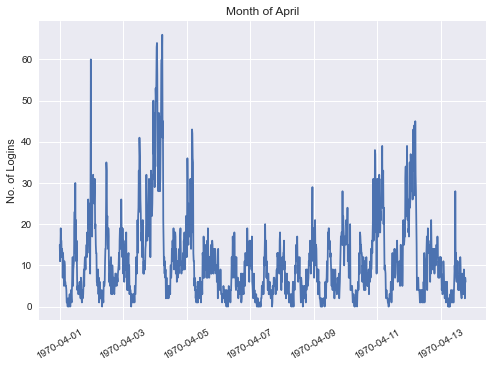

In [91]:
#Apr

plt.plot(df_15min['1970-04-01': '1970-04-30'])
plt.xticks(rotation=30);
plt.title('Month of April')
plt.ylabel('No. of Logins')

In [92]:
#Monthly Data 
#lookin at monthly graphs, it looks like Mar had most logins, then Apr, Feb and January in descending order
df_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [93]:
df_15min.reset_index(inplace=True)

In [94]:
#summarizing by day of week
df_15min['weekday'] = df_15min['login_time'].dt.dayofweek
df_dayofweek = df_15min.sort_values(by='count', ascending=False)
df_dayCount = df_dayofweek[['count', 'weekday']]

df_dayCount = df_dayCount.groupby('weekday').sum().reset_index()
df_dayCount['weekday'] = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
df_dayCount

,weekday,count
0,Mon,8823
1,Tues,9268
2,Wed,10339
3,Thurs,11960
4,Fri,15208
5,Sat,19377
6,Sun,18167


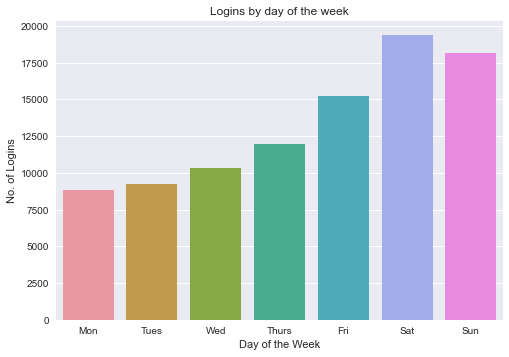

In [95]:

sns.barplot(x= 'weekday', y='count', data=df_dayCount)
plt.xlabel('Day of the Week')
plt.title('Logins by day of the week')
plt.ylabel('No. of Logins')
plt.show()

In [96]:
#from above plot we see that the number of login are more over the weekend. that is the clear trend we see here

In [97]:
#summarizing by day of week
df_15min['byhour'] = df_15min['login_time'].dt.hour
df_hr = df_15min.sort_values(by='count')
df_hrCount = df_hr[['count', 'byhour']]

df_hrCount = df_hrCount.groupby('byhour').sum().reset_index()
#df_dayCount['weekday'] = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
print("count by the hour")
df_hrCount

count by the hour


,byhour,count
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034
5,5,2945
6,6,1138
7,7,815
8,8,818
9,9,1527


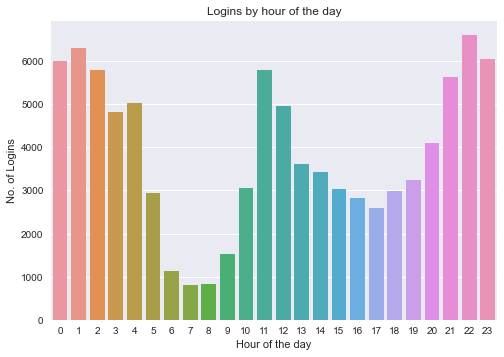

In [98]:
sns.barplot(x= 'byhour', y='count', data=df_hrCount)
plt.xlabel('Hour of the day')
plt.title('Logins by hour of the day')
plt.ylabel('No. of Logins')
plt.show()

Part 2: Experiment and metrics design
===============================
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
how you will implement the experiment.
what statistical test(s) you will conduct to verify the significance of the observation.
how you would interpret the results and provide recommendations to the city operations team along with any caveats.

1. The key measure that I will choose will be impact on activity happening in both cities after the experiment. 
And measure that as positive /negative or no impact. The increase in overall activity will definitely drive the profits up. So that is the rational behind choosing this metric.

2. I would suggest to use A/B testing variation for this. Step1 will be collect data. Before the experiment bagan what the data was. Once the experimane begin what the data is. Then next generate the hypothesis. And then present the data generated by two versions to the hypothesis and see if the two versions of data had a statistically significant difference.

Part 3: Predictive modeling
========================
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

In [99]:
def print_stats(col_name, group_by=False):
    """
    print the general statistics of the passed column
    """
    print('-'*60, '\n Individual Summary Statistics for', col_name, '\n', '-'*60)
    print('Describe \n',df_Users[col_name].describe(), '\n', '-'*20)
    print('Sample Observations \n',df_Users[col_name].sample(5), '\n', '-'*20)
    print('Number of Uniques \n',df_Users[col_name].nunique(), '\n', '-'*20)
    num_uniques = df_Users[col_name].nunique()
    if num_uniques <10: 
        print('Unique value counts \n', df_Users[col_name].value_counts(), '\n', '-'*20)
        
    if group_by:
        print('Group_by \n', df_Users.groupby('loan_status')[col_name].describe(), '\n','-'*20)

def plot_var(col_name, full_name, continuous):
    """
    plot a variable with and without loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name- for display purposes
    - continuous is True if the variable is continuous, False otherwise
    """
    #f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(df_Users.loc[df_Users[col_name].notnull(), col_name], kde=False)
    else:
        sns.countplot(df_Users[col_name], order=sorted(df_Users[col_name].unique()), color='#5975A4', saturation=1)
    #ax1.set_xlabel(full_name)
    #ax1.set_ylabel('Count')
    #ax1.set_title(full_name)

    
    #plt.tight_layout()

In [100]:
dataFile = open('ultimate_data_challenge.json', 'r').readline()

In [101]:
import json
data = json.loads(dataFile)
                 
df_Users = pd.DataFrame(data)
df_Users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [102]:
df_Users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [103]:
df_Users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [104]:
print_stats("city")

------------------------------------------------------------ 
 Individual Summary Statistics for city 
 ------------------------------------------------------------
Describe 
 count          50000
unique             3
top       Winterfell
freq           23336
Name: city, dtype: object 
 --------------------
Sample Observations 
 42799        Winterfell
46287    King's Landing
42030           Astapor
17223           Astapor
11285    King's Landing
Name: city, dtype: object 
 --------------------
Number of Uniques 
 3 
 --------------------
Unique value counts 
 Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64 
 --------------------


#Kings Landing seems to be less active in terms of users while Winterfell seems to be the most.

In [105]:
print_stats("signup_date")

------------------------------------------------------------ 
 Individual Summary Statistics for signup_date 
 ------------------------------------------------------------
Describe 
 count          50000
unique            31
top       2014-01-18
freq            2948
Name: signup_date, dtype: object 
 --------------------
Sample Observations 
 19554    2014-01-10
44564    2014-01-07
49599    2014-01-14
32459    2014-01-29
15346    2014-01-01
Name: signup_date, dtype: object 
 --------------------
Number of Uniques 
 31 
 --------------------


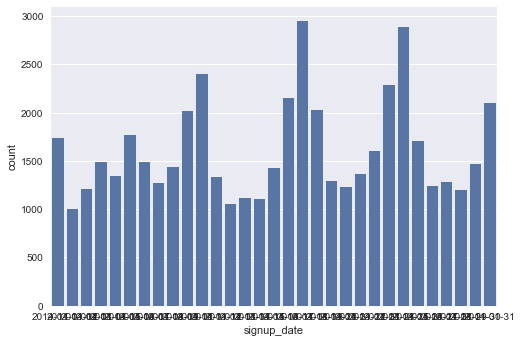

In [106]:

plot_var('signup_date', 'signup_date', continuous=False)

In [107]:
df_Users['signup_date'] = df_Users['signup_date'].apply(lambda x: pd.Timestamp(x, tz=None))
df_Users['last_trip_date'] = df_Users['last_trip_date'].apply(lambda x: pd.Timestamp(x, tz=None))

In [108]:
print_stats("avg_rating_of_driver")

------------------------------------------------------------ 
 Individual Summary Statistics for avg_rating_of_driver 
 ------------------------------------------------------------
Describe 
 count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64 
 --------------------
Sample Observations 
 44669    5.0
17349    NaN
16291    NaN
13327    4.7
47805    4.0
Name: avg_rating_of_driver, dtype: float64 
 --------------------
Number of Uniques 
 37 
 --------------------


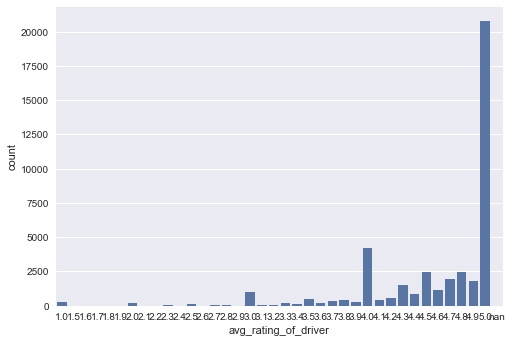

In [109]:
plot_var('avg_rating_of_driver', 'avg_rating_of_driver', continuous=False)

In [110]:
df_Users['avg_rating_of_driver'] = df_Users['avg_rating_of_driver'].fillna(df_Users['avg_rating_of_driver'].median())
df_Users['avg_rating_by_driver'] = df_Users['avg_rating_by_driver'].fillna(df_Users['avg_rating_by_driver'].median())

In [111]:
print_stats("phone")

------------------------------------------------------------ 
 Individual Summary Statistics for phone 
 ------------------------------------------------------------
Describe 
 count      49604
unique         2
top       iPhone
freq       34582
Name: phone, dtype: object 
 --------------------
Sample Observations 
 11749    Android
18530     iPhone
10380     iPhone
17320     iPhone
10152     iPhone
Name: phone, dtype: object 
 --------------------
Number of Uniques 
 2 
 --------------------
Unique value counts 
 iPhone     34582
Android    15022
Name: phone, dtype: int64 
 --------------------


In [112]:
df_Users['phone'] = df_Users['phone'].fillna('iPhone')

In [113]:
print_stats('last_trip_date')

------------------------------------------------------------ 
 Individual Summary Statistics for last_trip_date 
 ------------------------------------------------------------
Describe 
 count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object 
 --------------------
Sample Observations 
 6647    2014-06-22
29772   2014-01-25
22056   2014-04-13
47805   2014-01-04
34756   2014-05-30
Name: last_trip_date, dtype: datetime64[ns] 
 --------------------
Number of Uniques 
 182 
 --------------------


<AxesSubplot:>

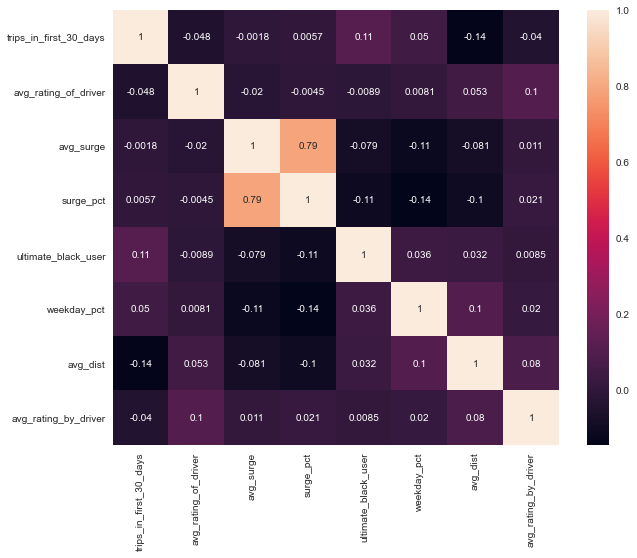

In [114]:

plt.figure(figsize=(10,8))
sns.heatmap(df_Users.corr(), annot=True)

In [115]:
df_Users['retained'] = np.nan
df_Users.loc[df_Users['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df_Users.loc[df_Users['last_trip_date'] < '2014-06-01', 'retained'] = 0

df_Users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1.0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0.0


In [116]:
df_Users = df_Users.drop('signup_date', axis=1)
df_Users = df_Users.drop('last_trip_date', axis=1)


In [117]:

# build dummy varialbles all categorical features
df_DUsers = pd.get_dummies(df_Users, columns = ['city', 'phone', 'ultimate_black_user'])

df_DUsers.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1.0,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0.0,0,0,1,1,0,1,0


In [118]:
train, test = train_test_split(df_DUsers, test_size=.30, 
                               random_state=42, stratify=df_DUsers['retained'])

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trips_in_first_30_days     35000 non-null  int64  
 1   avg_rating_of_driver       35000 non-null  float64
 2   avg_surge                  35000 non-null  float64
 3   surge_pct                  35000 non-null  float64
 4   weekday_pct                35000 non-null  float64
 5   avg_dist                   35000 non-null  float64
 6   avg_rating_by_driver       35000 non-null  float64
 7   retained                   35000 non-null  float64
 8   city_Astapor               35000 non-null  uint8  
 9   city_King's Landing        35000 non-null  uint8  
 10  city_Winterfell            35000 non-null  uint8  
 11  phone_Android              35000 non-null  uint8  
 12  phone_iPhone               35000 non-null  uint8  
 13  ultimate_black_user_False  35000 non-null  uin

In [120]:


y = train.retained
X = train.drop('retained', axis=1)

# model
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

# cross validation on train data
#cv = cross_validate(clf, X, y,scoring='precision_macro', cv=5,return_estimator=True)

classifier = GradientBoostingClassifier(verbose=True, n_estimators=200)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           1.2800            6.27s
         2           1.2440            6.28s
         3           1.2127            6.32s
         4           1.1851            6.37s
         5           1.1625            6.41s
         6           1.1423            6.46s
         7           1.1256            6.76s
         8           1.1099            6.65s
         9           1.0907            6.57s
        10           1.0786            6.51s
        20           0.9928            6.19s
        30           0.9587            5.80s
        40           0.9393            5.51s
        50           0.9273            5.21s
        60           0.9201            4.87s
        70           0.9146            4.53s
        80           0.9104            4.24s
        90           0.9071            3.87s
       100           0.9035            3.52s
       200           0.8802            0.00s


0.7859047619047619

<AxesSubplot:>

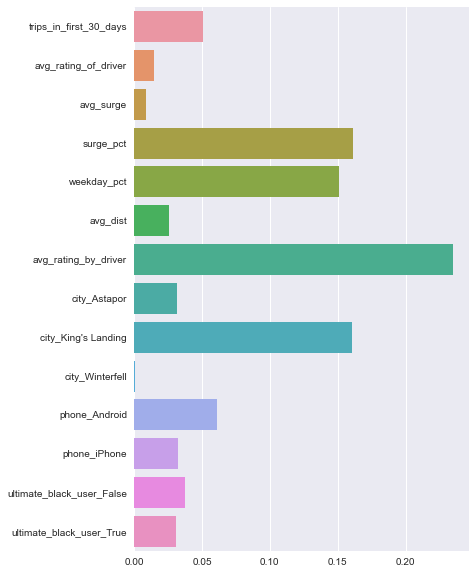

In [121]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_)

SUmmary-We used Gradient Boosting Classifier. The accuracy that was achieved was 79%. The features importance can be seen in the above plt. We could see that 'avg rating by driver' is the most significant feature. 